In [2]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import pickle

import pandas as pd
import xarray as xr
import seaborn as sns
import warnings
import logging
import cartopy.crs as ccrs
from skimage import measure 

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
settings_path = 'settings/obs_winter_30d.yaml'
fig_path = '/scratchx/mcarenso/tempest/figures/'
hdlr_obs_winter = handler.Handler(settings_path)
cs_obs_winter = casestudy.CaseStudy(hdlr_obs_winter, overwrite = False ,verbose = False)
gr_obs_winter = grid.Grid(cs_obs_winter, fast = True, overwrite= False, verbose_steps = False, verbose = False)

nbpd_fig1 = 20
nd = 4

jd_obs_winter = joint_distrib.JointDistribution(gr_obs_winter, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_75_Prec",
                                            nbpd = nbpd_fig1,  nd=nd, overwrite = True, dist_mask = False)

settings_path = 'settings/obs_summer_30d.yaml'
fig_path = '/scratchx/mcarenso/tempest/figures/'
hdlr_obs_summer = handler.Handler(settings_path)
cs_obs_summer = casestudy.CaseStudy(hdlr_obs_summer, overwrite = False ,verbose = False)
gr_obs_summer = grid.Grid(cs_obs_summer, fast = True, overwrite= False, verbose_steps = False, verbose = False)
jd_obs_summer = joint_distrib.JointDistribution(gr_obs_summer, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_75_Prec",
                                            nbpd = nbpd_fig1,  nd=nd, overwrite = True, dist_mask = False)

Data loaded from /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Data loaded from /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


In [5]:
### WINTER + SUMMER###
settings_paths = [
  # "settings/arpege_winter_30d.yaml", 
  # "settings/arpege_summer_30d.yaml", 

  # "settings/ifs_winter_30d.yaml" , 
  # "settings/ifs_summer_30d.yaml" , 
  
  # "settings/mpas_winter_30d.yaml", 
  # "settings/mpas_summer_30d.yaml", 
  
  # "settings/screamv1_winter_30d.yaml",
  # "settings/screamv1_summer_30d.yaml", 
 
  # "settings/sam_winter_30d.yaml", 
  # "settings/sam_summer_30d.yaml", 

  # "settings/um_winter_30d.yaml",
  # "settings/um_summer_30d.yaml",

  # "settings/xshield_winter_30d.yaml" , 
  # "settings/fv3_summer_30d.yaml", 
  
  # "settings/geos_winter_30d.yaml", 
  # "settings/grist_winter_30d.yaml", 
  # "settings/nicam_summer_30d.yaml", 
               ]

hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]
jds = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_75_Prec", 
        nbpd = 20,  nd=nd, overwrite = True, dist_mask = False) for gr in grs]

In [6]:
num_colors = 10
cmap = plt.get_cmap('hsv')
color_values = np.linspace(0, 0.9, num_colors)
model_colors = [cmap(value) for value in color_values]
model_colors[2] = (1.0, 1.0, 0.0, 1.0) ## yellow
model_colors[3] = (0.6, 1.0, 0.0, 1.0) ## greenish yellow

model_names = [
        "ARPEGE", 
        "IFS", 
        "MPAS", 
        "SCREAMv1",
        "SAM", 
        "UM", 
        "XSHiELD", "FV3",
        "GEOS", 
        "GRIST", 
        "NICAM"
        ]

In [7]:
def find_plot_contour(self, ax_show , N_branch=60, offset_low = 1, offset_up=1, color = 'k', lstyle = '--', model_name = None):
    Z = self.norm_density.T
    # -- Branches
    Z_contour = np.copy(Z)
    # Z_contour[18:, 18:] = 1 ## this number actually depends on nd and nbpd and the general shape of the Y 
    cont = measure.find_contours(Z_contour, 1)
    N = N_branch
    # fit
    popt_1, x_1, y_1, popt_2, x_2, y_2, func = self._fit_branches(cont,N, offset_low, offset_up)
    x_branch_2 = y_branch_1 = np.linspace(5,N_branch,N_branch)
    y_branch_2 = func(x_branch_2,*popt_2)
    x_branch_1 = func(y_branch_1,*popt_1)

    # show branches
    ax_show.plot(x_branch_1,y_branch_1, color = color, linestyle = lstyle, linewidth = 1.5, alpha = 0.9)
    ax_show.plot(x_branch_2,y_branch_2, color = color, linestyle = lstyle, linewidth = 1.5, alpha = 0.9, label  = model_name)

    return ax_show


def save_data(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_data(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def check_and_create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

contour shapes :  (81, 81) (81, 81)
(497, 2)
Fitting 1st branch
1st branch successfully fitted
Fitting 2nd branch
2nd branch successfully fitted
(613, 2)
Fitting 1st branch
1st branch successfully fitted
Fitting 2nd branch
2nd branch successfully fitted


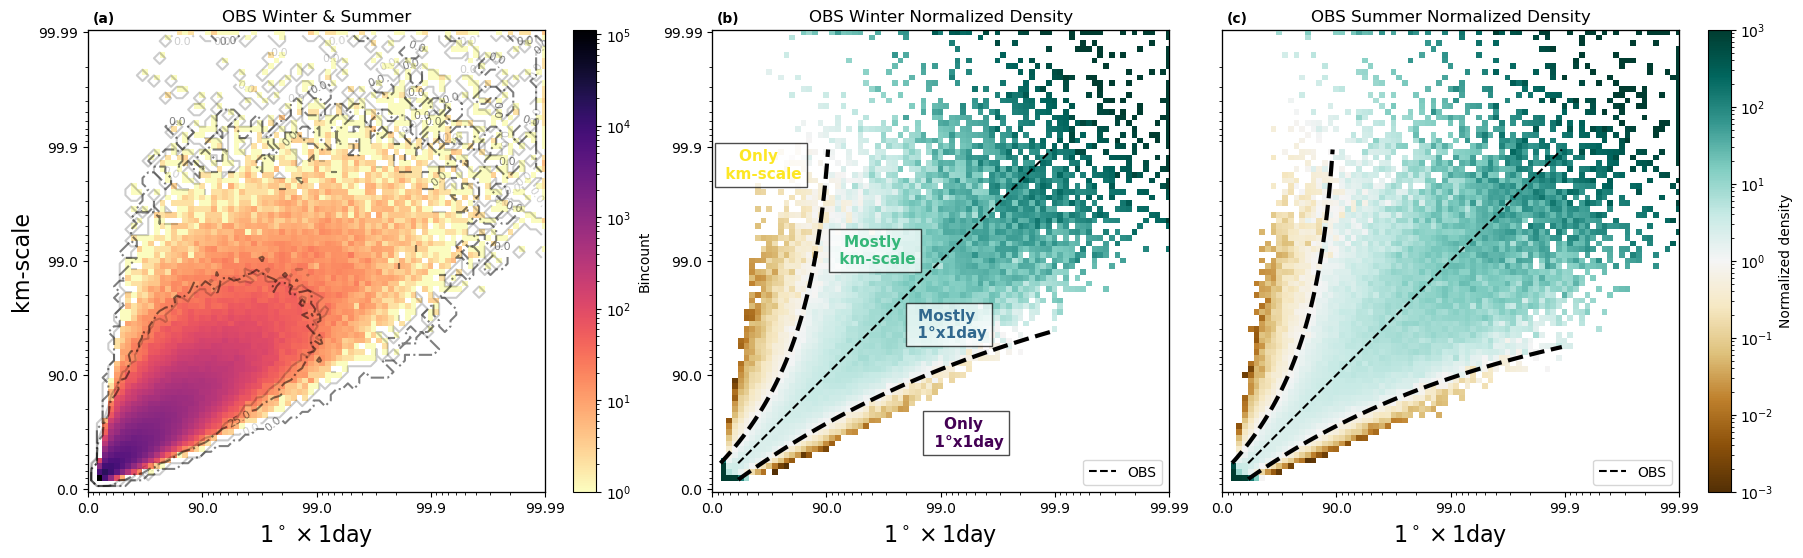

In [8]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from tempest.plots.plot2d import set_frame_invlog, show_joint_histogram

fig = plt.figure(figsize=(22, 6))
gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 0.8, 1])  # Adjust width ratios as needed

plt.subplots_adjust(wspace=0.1)  # Adjust horizontal (width) space

## Bincount 
ax = fig.add_subplot(gs[0, 0])

#levels for density contour
levels = [0, 25]
_, cb0 = jd_obs_winter.plot_data_contour(data = jd_obs_winter.bincount, contour=jd_obs_winter.bincount, contour_2=jd_obs_summer.bincount, levels = levels, scale = 'log', 
                     label  = 'Bincount',
                     cmap=plt.cm.magma_r, fig = fig, ax = ax, cb_bool=True)

ax.set_xlabel(r"1$^\circ\times 1$day", fontsize = 16)
ax.set_ylabel(r"km-scale", fontsize = 16)
ax.set_title(label = 'OBS Winter & Summer') 
ax.tick_params(axis='x')
ax.tick_params(axis='y') 
# cb0.ax.tick_params(labelsize=fontsize)  # Adjust font size of the tick labels
cb0.set_label('Bincount')  # Adjust font size of the colorbar label
ax.text(0.01, 1.04, "(a)", transform=ax.transAxes, fontweight='bold', va='top')


## Winter multiple branches PN 
ax = fig.add_subplot(gs[0, 1])

obs_model_name, obs_season = jd_obs_winter.settings["MODEL"].split("_")[0], jd_obs_winter.settings["MODEL"].split("_")[1]
_, cb ,ax_show1 = jd_obs_winter.plot(mask = False, branch=[True, True] , fig = fig, ax = ax, N_branch=60, model_name = obs_model_name, offset_low = 1, offset_up=1, cbar = False)

for i, jdi in enumerate(jds):
    color = model_colors[i//2]
    model_name, season = jdi.settings["MODEL"].split("_")[0], jdi.settings["MODEL"].split("_")[1]
    if model_name == "GRIST" : color = model_colors[(i+1)//2]

    if model_name in model_names :
        if season =="Winter":
            ls = "--" if season == "Winter" else "-."
            _, find_plot_contour(jdi, ax_show1, N_branch=60, offset_low = 1, offset_up=1, color = color, lstyle=ls, model_name = model_name)

ax.set_xlabel(r"1$^\circ\times 1$day", fontsize = 16) #,  
ax.set_ylabel("") # ax.set_ylabel(r"km-scale")
ax.set_title(label = obs_model_name+ " " + obs_season +" Normalized Density")#, fontsize = fontsize, fontname=fontname)
ax.tick_params(axis='x') #, labelsize=fontsize)
ax.tick_params(axis='y') #, labelsize=fontsize) 
ax_show1.legend(loc = "lower right")
# cb.ax.tick_params(labelsize=fontsize)  # Adjust font size of the tick labels
# cb.set_label('Normalized density')#, fontsize=fontsize)  # Adjust font size of the colorbar label

## Label boxs for winter only
labels = ['Only \n km-scale', 'Mostly \n km-scale', 'Mostly \n 1°x1day', 'Only \n 1°x1day']
# Colors sampled from viridis
values = np.array([1, 2, 3, 4])
cmap = mpl.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0.5, 5), cmap.N)
colors = cmap(norm(values))[::-1]
positions = [(9, 55), (29, 40), (42, 27), (45, 8)]  # Adjust positions of categories here

for label, color, position in zip(labels, colors, positions):
    text = ax_show1.text(position[0], position[1], label, fontsize=11, weight='bold', color=color, ha='center', bbox=dict(facecolor='white', alpha=0.7))
    # text.set_clip_on(False)
    text.set_zorder(2)
    # text.set_in_layout(True)
    # axs[1].annotate(label, position, fontsize=16, weight='bold', color=color, ha='center', bbox=dict(facecolor='white', alpha=0.7), zorder=1e5)

ax.text(0.01, 1.04, "(b)", transform=ax.transAxes, fontweight='bold', va='top')


## Summer multiple branches PN 
ax = fig.add_subplot(gs[0, 2])

obs_model_name, obs_season = jd_obs_summer.settings["MODEL"].split("_")[0], jd_obs_summer.settings["MODEL"].split("_")[1]
_,cb,ax_show2 = jd_obs_summer.plot(mask = False, branch=[True, True] , fig = fig, ax = ax, N_branch=60, model_name = obs_model_name, offset_low = 1, offset_up=1) #, cbar = False)

for i, jdi in enumerate(jds):
    color = model_colors[i//2]
    model_name, season = jdi.settings["MODEL"].split("_")[0], jdi.settings["MODEL"].split("_")[1]
    # print(model_name, color)
    if model_name in model_names :
        if season =="Summer":
            ls = "--" if season == "Summer" else "-."
            _, find_plot_contour(jdi, ax_show2, N_branch=60, offset_low = 1, offset_up=1, color = color, lstyle=ls, model_name = model_name)

ax.set_xlabel(r"1$^\circ\times 1$day", fontsize = 16) #,  fontsize = fontsize, fontname=fontname)
ax.set_ylabel(r"")  #ax.set_ylabel(r"km-scale")
ax.set_yticks([]) 

ax.set_title(label = obs_model_name+ " " + obs_season +" Normalized Density") #, fontsize = fontsize, fontname=fontname)
# ax.tick_params(axis='x') #, labelsize=fontsize)
# ax.tick_params(axis='y') #, labelsize=fontsize) 
ax_show2.legend(loc = "lower right")
# cb.ax.tick_params(labelsize=fontsize)  # Adjust font size of the tick labels
# cb.set_label('Normalized density') #, fontsize=fontsize)  # Adjust font size of the colorbar label

## Add cbs by hand for first rows
Z = jd_obs_summer.norm_density.T
scale = 'log'
vbds = (1e-3, 1e3)
cmap = plt.cm.BrBG
norm = LogNorm(vmin=vbds[0], vmax=vbds[1])  # Adjust vmin and vmax based on your data range

ax.text(0.01, 1.04, "(c)", transform=ax.transAxes, fontweight='bold', va='top')

plt.savefig("final_fig/fig4.pdf", bbox_inches = "tight", pad_inches=0.1)